In [1]:
import torch
torch.manual_seed(38)
from torch.utils.data import Dataset, DataLoader
from evaluate import evaluate
from model_utils import load_checkpoint
import net
from data_loader import *
import torch.optim as optim
import torch.nn as nn
import os
import cv2
import sys
sys.path.append("..")
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../Google_HDRplus/')
from hdrplus import HDRPlus_model
import json
from skimage.metrics import structural_similarity as ssim

In [2]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")
with open('args.json', 'r') as f:
    args.__dict__ = json.load(f)

args.__dict__['merge_ver']='m'
print(args)

Namespace(alternate_corr=False, ckpt_dir='ckpt/1104_12_19_mod/', logs_dir='runs/1104_12_19_mod/', merge_ver='m', mixed_precision=False, model_dir='.', note='train and eval on 1k hdr data captured on 11/04', restore_file='last', small=False)


In [3]:
model = net.Net(args).cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-4)
loss_fn = nn.L1Loss()

In [4]:
restore_path = os.path.join('ckpt/1104_12_19_mod/', 'last.pth.tar')

# 0922_20_45 : merge_mask
# 0928_19_43 : merge_mask w/ RAFT
# 0929_12_08 : merge_mask w/ RAFT train on larger dataset
# -------------- above are with mergenetM (conv4 filter_size = 1)
# 1003_00_18 : mergenetMP w layer6
# 1003_00_20 : mergenetMP w/o layer5&6
# 1003_00_42 : mergenet-[p]
# 1003_00_42t : mergenet-[p] fine-tuned on input_2.npy
# 1015_17_50: mergenet-[mp] w/o layer5&6
# 1015_22_29: mergenet-[m]
# 1104_12_19: mergenet-[m] on 4K HDR
model, optimizer, start_epoch, best_val_loss = load_checkpoint(restore_path, model, optimizer)
print("epoch:", start_epoch)

[*] Loaded model from ckpt/1104_12_19_mod/last.pth.tar
epoch: 200


In [5]:
eval_transformer =  GroupComposed([
    GroupToPILImage(mode = 'F'),
#     GroupRawRandomCrop(1536), ## random crop may cause broken Bayer pattern
    GroupToTensor()
])
# dataloader = DataLoader(HDRDataset(eval_transformer, 1, 'data/inputs_1015c.npy', 'data/gt_1015c.npy'),
#                             batch_size = 1, shuffle = True,
#                             num_workers = int(8),
#                             pin_memory=True)
dataloader = DataLoader(HDRDataset_1K(eval_transformer, 3, is_train = False),
                            batch_size = 1, shuffle = True,
                            num_workers = int(8),
                            pin_memory=True)
# dataloader =  DataLoader(LlrawSet(transform = eval_transformer, n_samples=1,frame_per_sample = 8, pos = 'mid'),
#                  batch_size = 1, shuffle = True,
#                  num_workers = int(8),
#                  pin_memory=True)
dataiter = iter(dataloader)

0.3805569


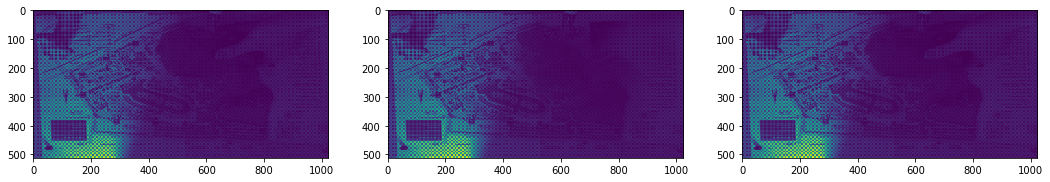

In [6]:
# for i in range(50):
window_size = 1024
val_batch, labels_batch = dataiter.next()
val_batch = val_batch[:, :, :512, :window_size]#.pow(1/2.2)
val_batch = torch.clamp(val_batch, 0., 1.)

labels_batch = labels_batch[:, :, :512, :window_size]#.pow(1/2.2)
labels_batch = torch.clamp(labels_batch, 0., 1.)


gamma_val = 2.2
bit_depth = 8
n_frames = 8

ref_idx = 0
ref = (val_batch[0, ref_idx].numpy()) 
# ref = (ref * (2**bit_depth-1)).astype(np.uint16)
avg = (np.mean(val_batch[0, :].numpy(), axis = 0))
# avg = (avg* (2**bit_depth*n_frames-1)).astype(np.uint16)
gt = (labels_batch[0, 0].cpu().numpy())
# gt = (gt *  (2**bit_depth*n_frames-1)).astype(np.uint16)
print(gt.max())
fig, ax = plt.subplots(1, 3, figsize=(18, 10)) ## different figure size may lead to block-like display. Dont know why.
ax[0].imshow(ref)
ax[1].imshow(avg)
ax[2].imshow(gt)
plt.show()

#### visual without gamma correction:

## single frame

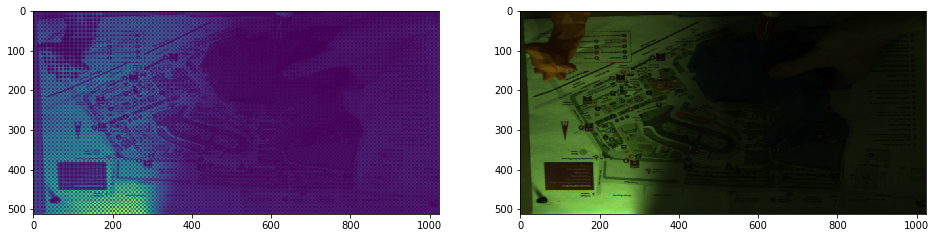

In [7]:
rgb_ref_raw = cv2.cvtColor((ref/ref.max()*65535.).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
# rgb_ref_raw = adjustColor(rgb_ref,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ref)
ax[1].imshow(rgb_ref_raw/rgb_ref_raw.max())
plt.show()

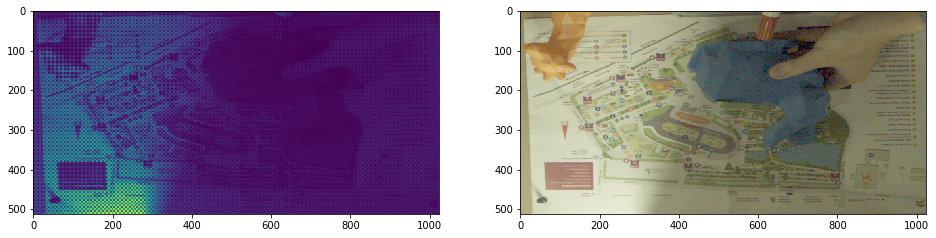

In [8]:
rgb_ref = cv2.cvtColor((ref/ref.max()*65535.).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
rgb_ref = adjustColor(rgb_ref,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ref)
ax[1].imshow(rgb_ref)
plt.show()

ref shape:  (512, 1024) dtype: float32
ref stat: max: 0.3960784375667572, min: 0.0, mean: 0.045537352561950684, std: 0.05432179942727089


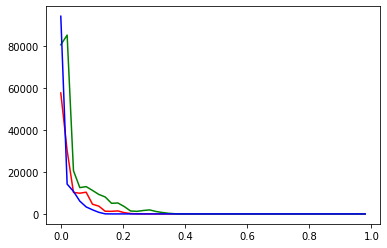

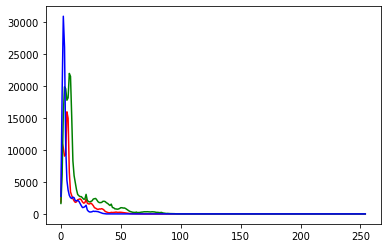

PSNR = 51.36025 -- SSIM = 0.98343


In [9]:
print_stat("ref", ref)
plot_histogram_normalized(ref)
plot_histogram((ref*(2**bit_depth-1)).astype(np.int16), bit_depth)
# loss = np.abs(ref[32:-32,32:-32]-gt[32:-32,32:-32]).mean()
PSNR = psnr(ref[32:-32,32:-32], gt[32:-32,32:-32])
SSIM = ssim(gt[32:-32,32:-32], ref[32:-32,32:-32], data_range=ref[32:-32,32:-32].max() - ref[32:-32,32:-32].min())
print("PSNR = {:.5f} -- SSIM = {:.5f}".format(PSNR, SSIM))

## 8 frames average

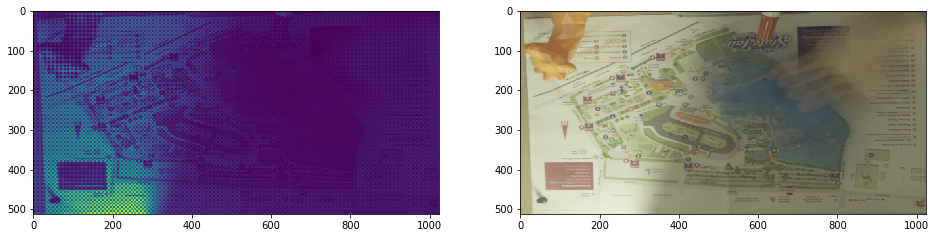

In [10]:
rgb_avg = cv2.cvtColor((avg/avg.max()*65535.).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
rgb_avg = adjustColor(rgb_avg,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(avg)
ax[1].imshow(rgb_avg)
plt.show()

avg shape:  (512, 1024) dtype: float32
avg stat: max: 0.3857842981815338, min: 0.0, mean: 0.04533808305859566, std: 0.054365478456020355


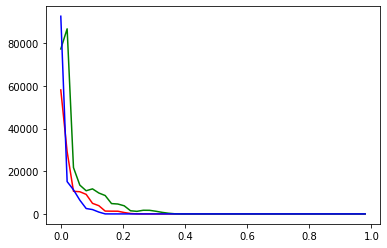

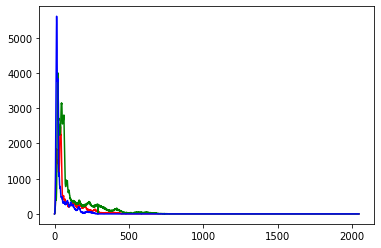

PSNR = 48.71305 -- SSIM = 0.95606


In [11]:
print_stat("avg", avg)
plot_histogram_normalized(avg)
plot_histogram((avg*(2**bit_depth*8-1)).astype(np.int16), bit_depth + np.log2(n_frames))
# loss = np.abs(avg[32:-32,32:-32]-gt[32:-32,32:-32]).mean()
PSNR = psnr(avg[32:-32,32:-32], gt[32:-32,32:-32])
SSIM = ssim(gt[32:-32,32:-32], avg[32:-32,32:-32], data_range=avg[32:-32,32:-32].max() - avg[32:-32,32:-32].min())
print("PSNR = {:.5f} -- SSIM = {:.5f}".format(PSNR, SSIM))

## Ground Truth

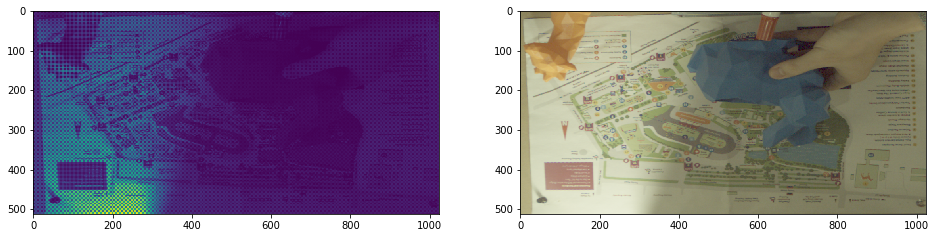

In [12]:
rgb_gt = cv2.cvtColor((gt/gt.max()*65535.0).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
rgb_gt = adjustColor(rgb_gt,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(gt)
ax[1].imshow(rgb_gt)
plt.show()

gt shape:  (512, 1024) dtype: float32
gt stat: max: 0.3805569112300873, min: 0.0, mean: 0.045408278703689575, std: 0.054078057408332825


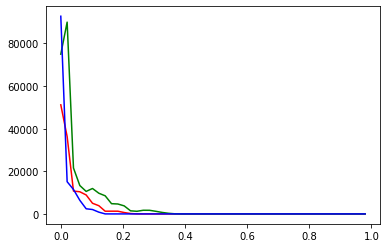

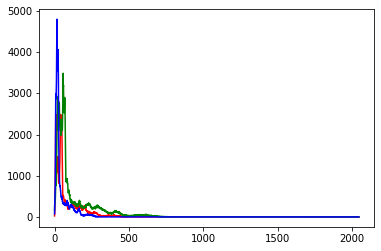

In [13]:
print_stat("gt", gt)
plot_histogram_normalized(gt)
plot_histogram((gt*(2**bit_depth*8-1)).astype(np.int16), bit_depth + np.log2(n_frames))

## prediction

In [14]:
cuda=True
model.eval()

with torch.no_grad():
#     for i, (val_batch, labels_batch) in enumerate(dataloader):
#         val_batch = val_batch[:, :, :1024, :1024]
#         labels_batch = labels_batch[:, :, :1024, :1024]
    n_seq = val_batch.size(1)
    output_batch = val_batch[:, ref_idx:ref_idx+1].clone()
#     if cuda:
#         output_batch = output_batch.cuda(non_blocking=True)
#     val_batch_cuda = val_batch.cuda(non_blocking=True)
    for j in range(0, n_seq):
        if j == ref_idx:
            continue
        print("processing {}th image....".format(j))
        input_batch = val_batch[:, [ref_idx, j]]#torch.cat([val_batch_cuda[:, 0:1], val_batch_cuda[:, j:j+1]], dim = 1)
        if cuda:
#             input_batch, labels_batch = input_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
            input_batch = input_batch.cuda(non_blocking=True)

#         res = model(input_batch)
#                 output_batch = res
        output_batch += model(input_batch).detach().cpu()
#             #########
#             output_batch = torch.sigmoid(output_batch)
    output_batch = output_batch/float(n_seq)
    output_batch = torch.clamp(output_batch, min=0., max=1.)

processing 1th image....
processing 2th image....
processing 3th image....
processing 4th image....
processing 5th image....
processing 6th image....
processing 7th image....


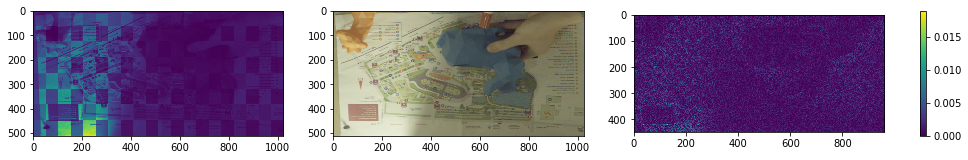

In [15]:
# output = (output_batch[0, 0].detach().numpy() * (2**bit_depth*n_frames-1)).astype(np.uint16)
output = output_batch[0, 0].detach().numpy()
rgb_output = cv2.cvtColor((output/output.max()*65535.).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
rgb_output = adjustColor(rgb_output,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
# cv2.imwrite("output_{}.jpg".format(ref_idx), rgb_output[..., ::-1])
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(output)
ax[1].imshow(rgb_output)
im = ax[2].imshow(np.abs(output[32:-32,32:-32]-gt[32:-32,32:-32]))
fig.colorbar(im, ax=ax,fraction=0.007, pad=0.04)
plt.show()

output shape:  (512, 1024) dtype: float32
output stat: max: 0.3845606744289398, min: 3.82783509849105e-05, mean: 0.045351143926382065, std: 0.054171301424503326


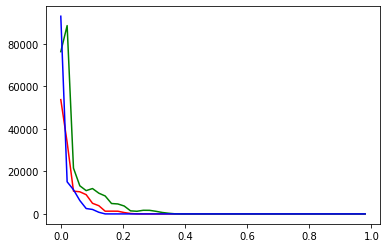

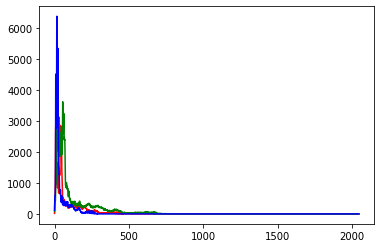

PSNR = 56.19819 -- SSIM = 0.99416


In [16]:
print_stat("output", output)
plot_histogram_normalized(output)
plot_histogram((output*(2**bit_depth*8-1)).astype(np.int16), bit_depth + np.log2(n_frames))
# loss = np.abs(output[32:-32,32:-32]-gt[32:-32,32:-32]).mean()
PSNR = psnr(output[32:-32,32:-32], gt[32:-32,32:-32])
SSIM = ssim(gt[32:-32,32:-32], output[32:-32,32:-32], data_range=output[32:-32,32:-32].max() - output[32:-32,32:-32].min())
print("PSNR = {:.5f} -- SSIM = {:.5f}".format(PSNR, SSIM))
# plt.savefig('output_hist.png')

## HDRPlus (!!Need to adjust merge threshold!!)

In [17]:
val_imgs = (val_batch[0].numpy()*1024.0).astype(np.int16) #* (2**bit_depth -1)).astype(np.uint16)
output_hdrplus = HDRPlus_model(val_imgs, 1500.0)#.astype(np.uint16)

merging 1th alternative frame
merging 2th alternative frame
merging 3th alternative frame
merging 4th alternative frame
merging 5th alternative frame
merging 6th alternative frame
merging 7th alternative frame


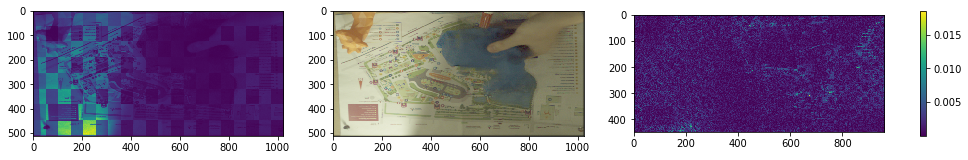

In [18]:
output_hdrplus = output_hdrplus/(1024.0*8-1)
rgb_hdrp = cv2.cvtColor((output_hdrplus/output_hdrplus.max()*65535.).astype(np.uint16), cv2.COLOR_BAYER_BG2RGB)
rgb_hdrp = adjustColor(rgb_hdrp,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(output_hdrplus)
ax[1].imshow(rgb_hdrp)
im = ax[2].imshow(np.abs(output_hdrplus[32:-32,32:-32]-gt[32:-32,32:-32]))
fig.colorbar(im, ax=ax,fraction=0.007, pad=0.04)
plt.show()

output_hdrplus shape:  (512, 1024) dtype: float64
output_hdrplus stat: max: 0.36898756823558887, min: 0.0, mean: 0.04429840208183619, std: 0.053301071976041725


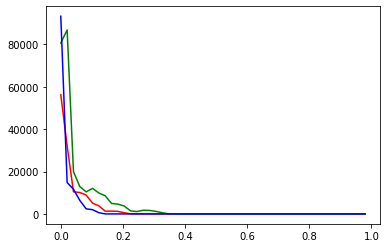

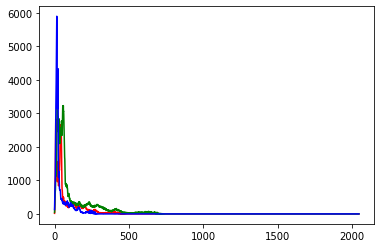

PSNR = 54.98047 -- SSIM = 0.98863


In [19]:
print_stat("output_hdrplus", output_hdrplus)
plot_histogram_normalized(output_hdrplus)
plot_histogram((output_hdrplus*(2**bit_depth*8-1)).astype(np.int16), bit_depth + np.log2(n_frames))
# loss = np.abs(output_hdrplus[32:-32,32:-32]-gt[32:-32,32:-32]).mean()
PSNR = psnr(output_hdrplus[32:-32,32:-32], gt[32:-32,32:-32])
SSIM = ssim(gt[32:-32,32:-32], output_hdrplus[32:-32,32:-32], 
            data_range=output_hdrplus[32:-32,32:-32].max() - output_hdrplus[32:-32,32:-32].min())
print("PSNR = {:.5f} -- SSIM = {:.5f}".format(PSNR, SSIM))

## comparison

From left to right: ref, hdr+ frame, pred frame, gt

From left to right: ref, hdr+ frame, pred frame, gt


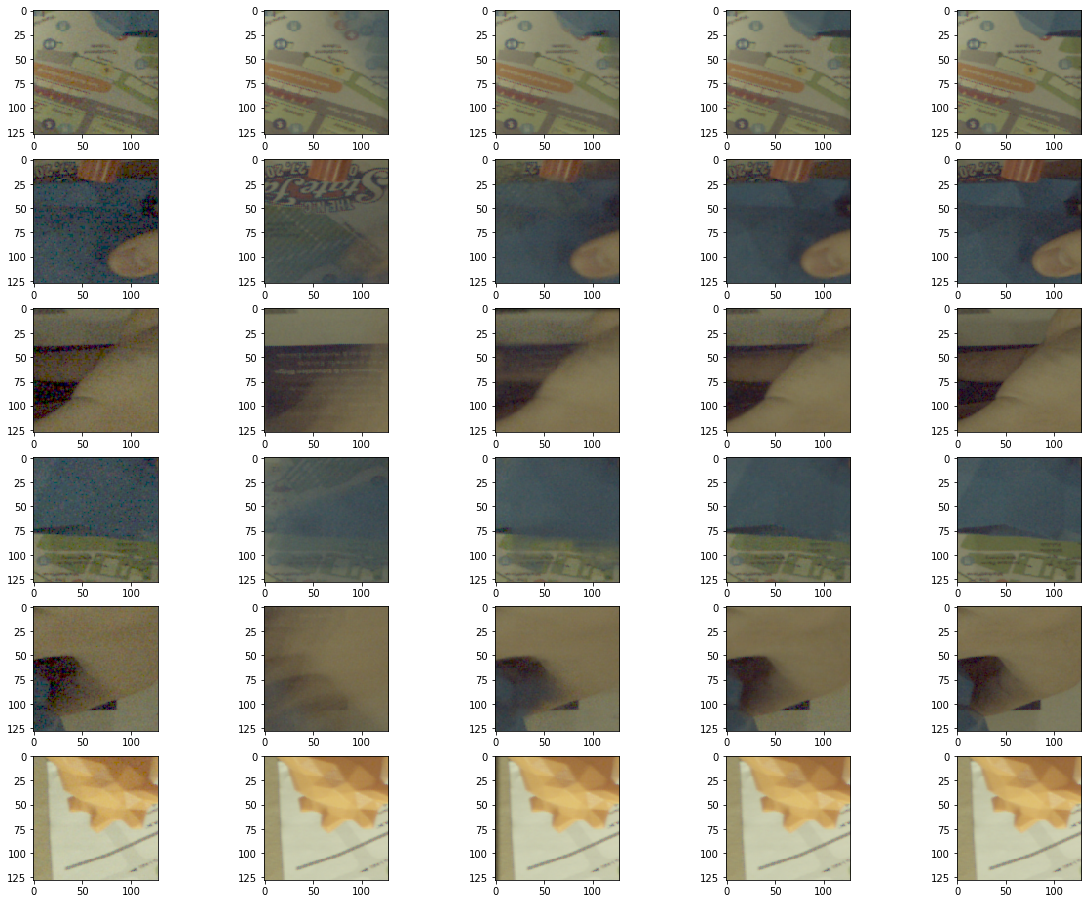

In [20]:
visual_list = [(200, 400), (50, 550), (0, 700), (150, 500), (90, 750), (100, 0)]
print("From left to right: ref, hdr+ frame, pred frame, gt")
fig, ax = plt.subplots(len(visual_list), 5, figsize=(20, 16))
for i, (x, y) in enumerate(visual_list):
    ax[i][0].imshow(rgb_ref[x:x+128, y:y+128])
    ax[i][1].imshow(rgb_avg[x:x+128, y:y+128])
    ax[i][2].imshow(rgb_hdrp[x:x+128, y:y+128])
    ax[i][3].imshow(rgb_output[x:x+128, y:y+128])
    ax[i][4].imshow(rgb_gt[x:x+128, y:y+128])
plt.show()

In [21]:
# fig, ax = plt.subplots(3, 4, figsize=(20, 16))
# ax[0][0].imshow(rgb_ref[100:100+256, 155:155+256])
# ax[0][1].imshow(rgb_hdrp[100:100+256, 155:155+256])
# ax[0][2].imshow(rgb_output[100:100+256, 155:155+256])
# ax[0][3].imshow(rgb_gt[100:100+256, 155:155+256])
# ax[1][0].imshow(rgb_ref[750:750+256, 400:400+256])
# ax[1][1].imshow(rgb_hdrp[750:750+256, 400:400+256])
# ax[1][2].imshow(rgb_output[750:750+256, 400:400+256])
# ax[1][3].imshow(rgb_gt[750:750+256, 400:400+256])
# ax[2][0].imshow(rgb_ref[400:400+256, 600:600+256])
# ax[2][1].imshow(rgb_hdrp[400:400+256, 600:600+256])
# ax[2][2].imshow(rgb_output[400:400+256, 600:600+256])
# ax[2][3].imshow(rgb_gt[400:400+256, 600:600+256])
# plt.show()

#### save images

In [22]:
# def draw_boxes(img):
#     img = add_window(img, 100, 155, 'r', win_size = 180)
#     img = add_window(img, 800, 400, 'g', win_size = 180)
#     img = add_window(img,400, 600, 'c', win_size = 180)
#     return img

In [23]:
# rgb_gt_w_win = draw_boxes(rgb_gt)
# fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# ax[0].imshow(rgb_gt_w_win)
# ax[1].imshow(rgb_gt)
# plt.show()
# # cv2.imwrite("rgb_gt", rgb_gt

In [24]:
# cv2.imwrite("rgb_gt.png", rgb_gt[..., ::-1])
# cv2.imwrite("rgb_gt_wbox.png", draw_boxes(rgb_gt)[..., ::-1])

# cv2.imwrite("rgb_ref.png", rgb_ref[..., ::-1])
# cv2.imwrite("rgb_ref_wbox.png", draw_boxes(rgb_ref)[..., ::-1])

# cv2.imwrite("rgb_hdrp.png", rgb_hdrp[..., ::-1])
# cv2.imwrite("rgb_hdrp_wbox.png", draw_boxes(rgb_hdrp)[..., ::-1])

# cv2.imwrite("rgb_output.png", rgb_output[..., ::-1])
# cv2.imwrite("rgb_output_wbox.png", draw_boxes(rgb_output)[..., ::-1])

# cv2.imwrite("rgb_avg.png", rgb_avg[..., ::-1])
# cv2.imwrite("rgb_avg_wbox.png", draw_boxes(rgb_avg)[..., ::-1])

In [25]:
# def save_imgs(name, img):
#     cv2.imwrite(name+"_p1.png", img[100:100+180, 155:155+180, ::-1])
#     cv2.imwrite(name+"_p2.png", img[800:800+180, 400:400+180, ::-1])
#     cv2.imwrite(name+"_p3.png", img[400:400+180, 600:600+180, ::-1])

In [26]:
# save_imgs("rgb_gt", draw_boxes(rgb_gt))
# save_imgs("rgb_ref", draw_boxes(rgb_ref))
# save_imgs("rgb_hdrp", draw_boxes(rgb_hdrp))
# save_imgs("rgb_output", draw_boxes(rgb_output))
# save_imgs("rgb_avg", draw_boxes(rgb_avg))